# Project

This notebook will go though the various aspects of iteration through the various python scripts used as part of this project. 

https://www.met.ie/climate/available-data/historical-data

## Section X - Importing modules and initia data processing

In [239]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import python_scripts.project_functions as pf
import python_scripts.data_processing as dp 

plt.style.use('seaborn-v0_8')

In [240]:
# zipped_data = 'data\\hly2375.zip'
# dst_dir = 'data\\'

# # Unzip the combined zip file
# with zipfile.ZipFile(zipped_data, 'r') as zip_ref:
#     zip_ref.extractall(dst_dir)

In [241]:
# pf.extract_zip('data\\hly2375.zip', 'data\\')

import data

In [242]:
# setting low_memory to false to stop guessing of column dtypes as this is memory intensive
path = 'data\\hly2375.csv'
data = pd.read_csv(path, skiprows=22, low_memory=False)

print(data.shape)
print(data.head())

(597898, 21)
                date  ind  rain  ind.1  temp  ind.2  wetb  dewpt  vappr  rhum  \
0  16-sep-1956 15:00    0   0.0      0  14.4      0  12.1   10.0   12.4    76   
1  16-sep-1956 16:00    0   0.0      0  13.9      0  11.6    9.4   11.9    75   
2  16-sep-1956 17:00    0   0.0      0  14.2      0  12.0   10.0   12.3    76   
3  16-sep-1956 18:00    0   0.0      0  13.0      0  11.6   10.0   12.6    85   
4  16-sep-1956 19:00    0   0.0      0  12.6      0  11.7   11.1   13.1    90   

   ...  ind.3  wdsp ind.4  wddir ww  w  sun    vis clht clamt  
0  ...      1     0     1      0  1  2  0.1  16000  200     5  
1  ...      1     0     1      0  1  1  0.1  24000  999     4  
2  ...      1     0     1      0  3  1  0.4  19000   90     5  
3  ...      1     0     1      0  1  1  0.0  30000   45     4  
4  ...      1     0     1      0  3  2  0.0  28000   40     7  

[5 rows x 21 columns]


In [243]:
print(np.min(data.date),np.max(data.date))
# the first year is 1956, and the last date is in December 2024 so need to add the date column as the index. 

01-apr-1957 00:00 31-oct-2024 23:00


Several data processing operations need to be completed, and initially the `date` was changed to a datetime oject and then some data extration (such as decades and season) was done. Then a `DataProcessor` class was added to make some operations easier, but then some of the functions didn't work as well with `.strftime` . For this, data extraction was done to the `date` column before changing it to a datetime object. 

Season was also extracted. While a `pd.resample` could be used, this only has quarters and not true seasons. Using similar data from Met Éireann, [Murphy et al., 2023](https://www.sciencedirect.com/science/article/pii/S2212094723000610) break down the seasons into from the months below;
- Winter: Dec, Jan, and Feb
- Spring: Mar, Apr, and May
- Summer: Jun, Jul, and Aug
- Autumn: Sep, Oct, and Nov

Data extraction operations include
- Capitilizing name of month 
- Extracting month and season 
- Extracting year and decade

In [244]:
# firstly capitalise the first letter of month

# Apply the function to the date column
data['date'] = data['date'].apply(pf.capitalize_month)

print(data.head())

                date  ind  rain  ind.1  temp  ind.2  wetb  dewpt  vappr  rhum  \
0  16-Sep-1956 15:00    0   0.0      0  14.4      0  12.1   10.0   12.4    76   
1  16-Sep-1956 16:00    0   0.0      0  13.9      0  11.6    9.4   11.9    75   
2  16-Sep-1956 17:00    0   0.0      0  14.2      0  12.0   10.0   12.3    76   
3  16-Sep-1956 18:00    0   0.0      0  13.0      0  11.6   10.0   12.6    85   
4  16-Sep-1956 19:00    0   0.0      0  12.6      0  11.7   11.1   13.1    90   

   ...  ind.3  wdsp ind.4  wddir ww  w  sun    vis clht clamt  
0  ...      1     0     1      0  1  2  0.1  16000  200     5  
1  ...      1     0     1      0  1  1  0.1  24000  999     4  
2  ...      1     0     1      0  3  1  0.4  19000   90     5  
3  ...      1     0     1      0  1  1  0.0  30000   45     4  
4  ...      1     0     1      0  3  2  0.0  28000   40     7  

[5 rows x 21 columns]


Setting the `date` column to be index. In a similar fashion to [here](https://github.com/EllenMcG/PFDA/blob/main/assignments/assignment_6_weather.ipynb).

In [245]:
# Apply the function to add month and season columns
data = pf.add_month_and_season(data)

In [246]:
data = pf.add_year_and_decade(data)
# print(data.head())

# data['year'] = data['date'].apply(pf.extract_year)
# print(data.head())

In [247]:
# setting date to index and sorting by index to ensure data is sorted properly 
# data.set_index('date', inplace=True)
# data.index = pd.to_datetime(data.index)

# # sort values
# sorted_index = data.index.sort_values()
# data = data.loc[sorted_index]
processor = dp.DataProcessor(data)
processor.convert_to_datetime('date')
print(data.head())

                     ind  rain  ind.1  temp  ind.2  wetb  dewpt  vappr  rhum  \
date                                                                           
1956-09-16 15:00:00    0   0.0      0  14.4      0  12.1   10.0   12.4    76   
1956-09-16 16:00:00    0   0.0      0  13.9      0  11.6    9.4   11.9    75   
1956-09-16 17:00:00    0   0.0      0  14.2      0  12.0   10.0   12.3    76   
1956-09-16 18:00:00    0   0.0      0  13.0      0  11.6   10.0   12.6    85   
1956-09-16 19:00:00    0   0.0      0  12.6      0  11.7   11.1   13.1    90   

                        msl  ...  ww  w  sun    vis clht clamt month  season  \
date                         ...                                               
1956-09-16 15:00:00  1026.7  ...   1  2  0.1  16000  200     5   Sep  Autumn   
1956-09-16 16:00:00  1026.6  ...   1  1  0.1  24000  999     4   Sep  Autumn   
1956-09-16 17:00:00  1026.4  ...   3  1  0.4  19000   90     5   Sep  Autumn   
1956-09-16 18:00:00  1026.5  ...   1  1

## Section 1 - Comparison with a subset of data (used for testing)

While a `pd.resample` could be used, this only has quarters and not true seasons. Using similar data from Met Éireann, [Murphy et al., 2023](https://www.sciencedirect.com/science/article/pii/S2212094723000610) break down the seasons into from the months below;
- Winter: Dec, Jan, and Feb
- Spring: Mar, Apr, and May
- Summer: Jun, Jul, and Aug
- Autumn: Sep, Oct, and Nov



In [248]:
data_subsampled = data.sample(n=1000, random_state=42)
print(data_subsampled.head())
print(data_subsampled.shape)

                     ind  rain  ind.1  temp  ind.2  wetb  dewpt  vappr  rhum  \
date                                                                           
1963-04-13 11:00:00    0   0.2      0   7.8      0   5.8    3.0    7.6    72   
1979-08-19 04:00:00    2   0.0      0  12.6      0  11.6   11.0   12.8    88   
1970-06-12 23:00:00    2   0.0      0  14.4      0  14.1   14.0   15.8    97   
2001-02-16 15:00:00    0   0.0      0   8.0      0   6.6    4.8    8.6    80   
1962-01-22 08:00:00    0   0.0      0   5.6      0   3.5    0.0    6.2    68   

                        msl  ...  ww   w  sun    vis clht clamt month  season  \
date                         ...                                                
1963-04-13 11:00:00  1009.1  ...  25   8  0.8  19000   19     6   Apr  Spring   
1979-08-19 04:00:00  1019.7  ...  50   5  0.0   3000    2     8   Aug  Summer   
1970-06-12 23:00:00  1018.6  ...  50   5  0.0   3200    4     8   Jun  Summer   
2001-02-16 15:00:00  1037.2  ...  

In [249]:
# # Plotting the temperature over time
# fig, ax = plt.subplots(figsize=(10,6))
# sns.lineplot(data=data_condensed,x=data_condensed.index,y='temp')
# ax.set_ylabel('Temperature ($^{\circ}C$)')
# ax.set_xlabel('Date')
# ax.set_title('Temperature ($^{\circ}C$) over Time');

In [250]:
# testing will full dataset
# data = pf.add_month_and_season(data)

In [251]:
# # Plotting the temperature over time
# fig, ax = plt.subplots(figsize=(10,6))
# sns.lineplot(data=data,x=data.index,y='temp')
# ax.set_ylabel('Temperature ($^{\circ}C$)')
# ax.set_xlabel('Date')
# ax.set_title('Temperature ($^{\circ}C$) over Time');

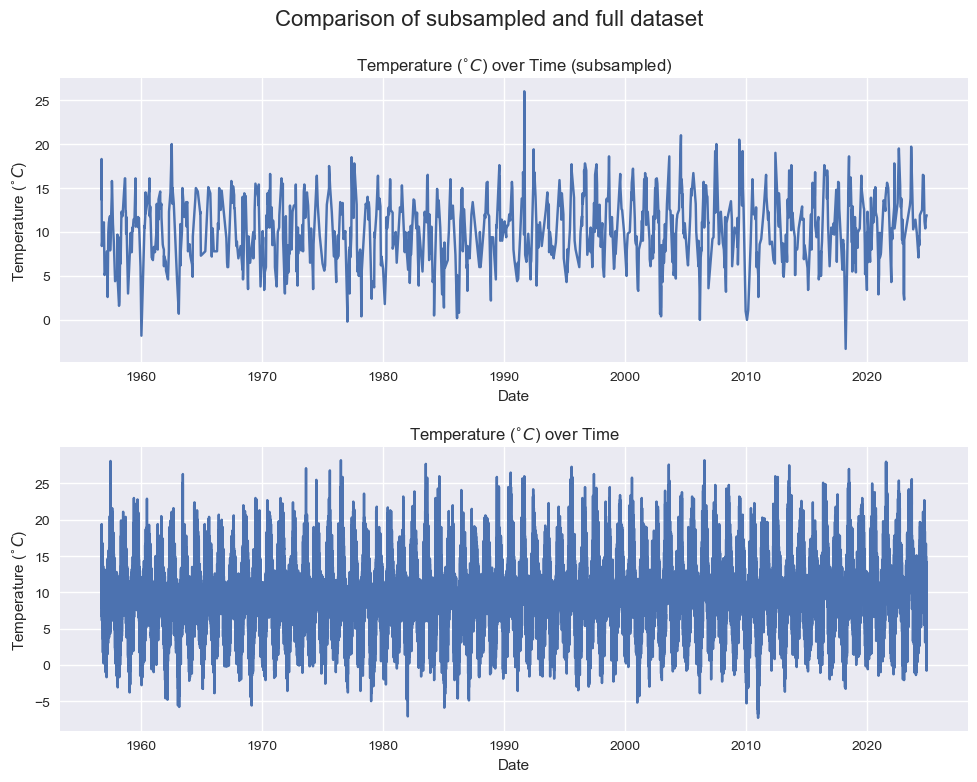

In [252]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

fig.suptitle('Comparison of subsampled and full dataset', fontsize=16)

sns.lineplot(data=data_subsampled,x=data_subsampled.index,y='temp', ax=ax1)
ax1.set_ylabel('Temperature ($^{\circ}C$)')
ax1.set_xlabel('Date')
ax1.set_title('Temperature ($^{\circ}C$) over Time (subsampled)')

sns.lineplot(data=data,x=data.index,y='temp', ax=ax2)
ax2.set_ylabel('Temperature ($^{\circ}C$)')
ax2.set_xlabel('Date')
ax2.set_title('Temperature ($^{\circ}C$) over Time')

plt.tight_layout();

## Section 2 - Seasonality 

Adding decades for plotting 

In [253]:
# Plotting the temperature by season over time (decades)
# data = pf.add_year_and_decade(data)

## Section 3 - Power Analysis 

In [254]:
a = data['wdsp'].unique()
print(a)

# a = data['wdsp'].isnull().sum()
# print(a)

# b = data['wdsp'].value_counts()
# print(b)

['0' '9' '7' '4' '6' '8' '11' '12' '10' '5' '13' '14' '15' '18' '19' '17'
 '16' '21' '24' '22' '26' '20' '23' '3' '2' '1' '25' '36' '38' '34' '37'
 '29' '27' '28' '31' '30' '32' '33' '35' '41' '45' '49' '48' '43' '39'
 '40' '44' '58' '63' '47' '59' '56' '42' '46' '51' '50' '53' '55' '52'
 '54' '57' ' ']


In [255]:
c = data['wdsp'].str.startswith(' ').sum()
print(c)

1


In [256]:
data['wdsp'] = np.where(data['wdsp'].str.startswith(' '), np.nan, data['wdsp'])
d = data['wdsp'].isnull().sum()
print(d)

1


In [257]:
data['wdsp'] = data['wdsp'].bfill()

In [258]:
# a = data['wdsp'].unique()
# print(a)

In [259]:
data['power'] = pf.calculate_power(data['wdsp'].astype(int))
print(data.head())

                     ind  rain  ind.1  temp  ind.2  wetb  dewpt  vappr  rhum  \
date                                                                           
1956-09-16 15:00:00    0   0.0      0  14.4      0  12.1   10.0   12.4    76   
1956-09-16 16:00:00    0   0.0      0  13.9      0  11.6    9.4   11.9    75   
1956-09-16 17:00:00    0   0.0      0  14.2      0  12.0   10.0   12.3    76   
1956-09-16 18:00:00    0   0.0      0  13.0      0  11.6   10.0   12.6    85   
1956-09-16 19:00:00    0   0.0      0  12.6      0  11.7   11.1   13.1    90   

                        msl  ...  w  sun    vis clht clamt month  season  \
date                         ...                                           
1956-09-16 15:00:00  1026.7  ...  2  0.1  16000  200     5   Sep  Autumn   
1956-09-16 16:00:00  1026.6  ...  1  0.1  24000  999     4   Sep  Autumn   
1956-09-16 17:00:00  1026.4  ...  1  0.4  19000   90     5   Sep  Autumn   
1956-09-16 18:00:00  1026.5  ...  1  0.0  30000   45     4 

In [260]:
a = data.groupby('season')['power'].agg(['mean','median','std'])
print(a)

              mean     median         std
season                                   
Autumn  143.259231  57.640022  229.876901
Spring  125.841409  57.640022  196.443698
Summer   85.520088  44.397494  125.287603
Winter  198.113104  91.530221  316.164120


### Section X - Logisic Regression

In [261]:
 

# log_reg = dp.BinaryLogisticRegression(df, 'target')
# log_reg.preprocess_data()
# log_reg.train_model()
# log_reg.evaluate_model()


## Final exported dataset

In [262]:
# data.to_csv('data\\hly2375_cleaned.csv', index=True)

In [263]:
# data_condensed['year'] = data_condensed.index.year.astype('str')
# print(data_condensed.info())

### **References**
[Murphy et al., 2023](https://www.sciencedirect.com/science/article/pii/S2212094723000610)